## Toy example for a variational autoencoder

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
ver = tf.__version__
print("Tensor Flow version {}".format(ver))

Tensor Flow version 0.8.0


In [2]:
def next_batch(batch_size, non_crossing=True):
    z_true = np.random.uniform(0,1,batch_size)
    r = np.power(z_true, 0.5)
    phi = 0.25 * np.pi * z_true
    x1 = r*np.cos(phi)
    x2 = r*np.sin(phi)
    
    # Sampling form a Gaussian
    x1 = np.random.normal(x1, 0.10* np.power(z_true,2), batch_size)
    x2 = np.random.normal(x2, 0.10* np.power(z_true,2), batch_size)
        
    # Bringing data in the right form
    xx = np.transpose(np.reshape((x1,x2), (2, batch_size)))
    xx = np.asarray(xx, dtype='float32')
    return xx

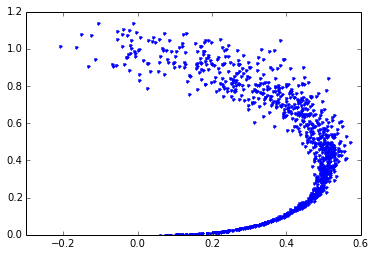

(1000, 2)

In [3]:
xx = next_batch(1000)
plt.plot(xx[:,0], xx[:,1], '.')
plt.show()
xx.shape

In [4]:
# Functions to get variables
def weights(shape):
  initial = tf.truncated_normal(shape, stddev=0.1)
  return tf.Variable(initial)

def bias(shape):
  initial = tf.constant(0.1, shape=shape)
  return tf.Variable(initial)

### Building the networks
#### The Decoder Network

The decoder network takes the input image and calculates the mean $\mu =$ `z_mu` and the log variance $\log\sigma^2 =$ `z_ls2` of the Gaussian, thus producing the latent variable z.

In [5]:
n_z = 1 #Dimension of the latent space
# Input
x = tf.placeholder("float32", shape=[None, 2]) #Batchsize x Number of Pixels
n_hidden = 5

# First hidden layer
W_fc1 = weights([2, n_hidden])
b_fc1 = bias([n_hidden])
h_1   = tf.nn.softplus(tf.matmul(x, W_fc1) + b_fc1)

# Parameters for the Gaussian
z_mu = tf.add(tf.matmul(h_1, weights([n_hidden, n_z])), bias([n_z]))
# A little trick:
#  sigma is always > 0.
#  We don't want to enforce that the network produces only positive numbers, therefore we let 
#  the network model the parameter log(\sigma^2).
z_ls2 = tf.add(tf.matmul(h_1, weights([n_hidden, n_z])), bias([n_z])) 

#### The Encoder Network

Samples from a Gaussian using the given mean and the std. The sampling is done by addding a random number ensuring that backpropagation works fine.

In [6]:
batch_size = 640
eps = tf.random_normal((batch_size, n_z), 0, 1, dtype=tf.float32) # Adding a random number
z = tf.add(z_mu, tf.mul(tf.sqrt(tf.exp(z_ls2)), eps))  # The sampled z

In [7]:
n_hidden = 5
W_fc1_g = weights([n_z, n_hidden])
b_fc1_g = bias([5])
h_1_g   = tf.nn.softplus(tf.matmul(z, W_fc1_g) + b_fc1_g)


x_mu = tf.add(tf.matmul(h_1_g,  weights([5, 2])), bias([2]))
x_ls2 = tf.add(tf.matmul(h_1_g,  weights([5, 2])), bias([2]))

#### Defining the loss function

##### The reconstruction error
We assume that the data x, is Gaussian distributed with diagnoal covariance matrix $\Sigma_{ij} = \delta_{i,j} \sigma_i^2$. The parameters of that Gaussian are determined by the encoder network. The reconstruction error for the $i-th$ example in the min-batch is given by 
$$
    \mathbb{E}_{q(z|x^{(i)})}\left( \log\left(p(x^{(i)}|z)\right)\right) 
$$
we approximate the expectation with samplinging from the distribution (even with $L=1$
$$
    \mathbb{E}_{q(z|x^{(i)})}\left( \log\left(p(x^{(i)}|z)\right)\right) \approx 
    \frac{1}{L} \sum_{i=1}^L \log\left(p(x^{(i)}|z^{(i,l)})\right) \approx \log\left(p(x^{(i)}|z^{(i,l)})\right)
$$

For the simple Gaussian, we obtain the following reconstruction error (neglegting a constant term)
$$
    -\log\left(p(x^{(i)}|z^{(i,l)})\right) = \sum_{j=1}^2 \frac{1}{2} \log(\sigma_j^2) + \frac{(x^{(i)}_j - \mu_j)^2}{2 \sigma_j^2}
$$

In [8]:
reconstr_loss = tf.reduce_sum(0.5 * x_ls2 + (tf.square(x-x_mu)/(2.0 * tf.exp(x_ls2))), 1)
latent_loss = -0.5 * tf.reduce_sum(1 + z_ls2 - tf.square(z_mu) - tf.exp(z_ls2), 1)
cost = tf.reduce_mean(reconstr_loss + latent_loss)   # average over batch

# Use ADAM optimizer
optimizer =  tf.train.AdamOptimizer(learning_rate=0.01).minimize(cost)

In [9]:
runs = 2000 #Set to 0, for no training
init = tf.initialize_all_variables()
saver = tf.train.Saver()
with tf.Session() as sess:
    sess.run(init)
    batch_xs = next_batch(batch_size)
    print(batch_xs.shape)
    dd = sess.run([cost], feed_dict={x: batch_xs})
    print('Test run after starting {}'.format(dd))

    for epoch in range(runs):
        avg_cost = 0.
        batch_xs = next_batch(batch_size)
        _,d, z_mean_val, z_log_sigma_sq_val = sess.run((optimizer, cost, z_mu, z_ls2), feed_dict={x: batch_xs})
        avg_cost += d / batch_size

        # Display logs per epoch step
        if epoch % 10 == 0:
            save_path = saver.save(sess, "model_2d/model2d.ckpt") #Saves the weights (not the graph)
            print("Model saved in file: {}".format(save_path))
            print "Epoch:", '%04d' % (epoch+1), "cost=", "{:.9f}".format(avg_cost)
            print ("{} {} mean sigma2 {}".format(z_mean_val.min(), z_mean_val.max(), np.mean(np.exp(z_log_sigma_sq_val))))
            

(640, 2)
Test run after starting [0.16901378]
Model saved in file: model_2d/model2d.ckpt
Epoch: 0001 cost= 0.000252744
0.0478497184813 0.0572383068502 mean sigma2 1.15389597416
Model saved in file: model_2d/model2d.ckpt
Epoch: 0011 cost= -0.000624925
-0.0129674524069 -0.00371961295605 mean sigma2 0.959288299084
Model saved in file: model_2d/model2d.ckpt
Epoch: 0021 cost= -0.001383426
-0.0439148396254 -0.0349992439151 mean sigma2 1.02362418175
Model saved in file: model_2d/model2d.ckpt
Epoch: 0031 cost= -0.002115189
-0.105516195297 -0.0825691223145 mean sigma2 0.986367225647
Model saved in file: model_2d/model2d.ckpt
Epoch: 0041 cost= -0.002668601
-0.0929918512702 -0.0513258799911 mean sigma2 0.98716199398
Model saved in file: model_2d/model2d.ckpt
Epoch: 0051 cost= -0.002845656
-0.0421145483851 0.0127280727029 mean sigma2 0.977116942406
Model saved in file: model_2d/model2d.ckpt
Epoch: 0061 cost= -0.003141917
-0.0200131386518 0.0284056812525 mean sigma2 0.998445510864
Model saved in fi

In [10]:
saver = tf.train.Saver()
with tf.Session() as sess:
    saver.restore(sess, "model_2d/model2d.ckpt")
    x_sample = next_batch(batch_size)
    var = (x_mu, x_ls2, z, z_mu, z_ls2, cost, reconstr_loss, latent_loss)
    out = sess.run(var, feed_dict={x: x_sample})
    x_mu_val, x_ls2_val, z_vals, z_mu_val,z_ls2_val, cost_val, reconstr_loss_val,latent_loss_val = out

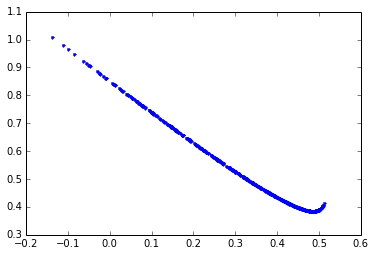

In [11]:
plt.plot(x_mu_val[:,0], x_mu_val[:,1], '.')

In [12]:
z_vals = np.reshape(np.asarray(np.linspace(-3,3, batch_size), dtype='float32'), (batch_size,1))

In [13]:
saver = tf.train.Saver()
with tf.Session() as sess:
    saver.restore(sess, "model_2d/model2d.ckpt")
    x_mu_val, x_ls2_val = sess.run((x_mu, x_ls2), feed_dict={z: z_vals})

(0.0020420712, 0.07642822)

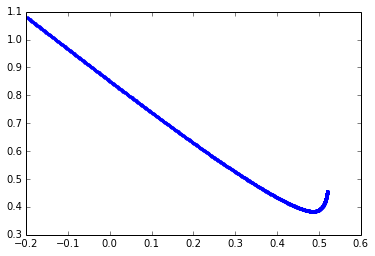

In [14]:
plt.plot(x_mu_val[:,0], x_mu_val[:,1], '.')
np.exp(x_ls2_val)[:,0].mean(), np.exp(x_ls2_val)[:,1].mean()

In [15]:
np.exp(x_ls2_val)

array([[  8.88025752e-05,   1.27376267e-03],
       [  9.00249288e-05,   1.29429472e-03],
       [  9.12637552e-05,   1.31515472e-03],
       ..., 
       [  1.58233382e-03,   8.33801925e-02],
       [  1.57332642e-03,   8.29975381e-02],
       [  1.56436069e-03,   8.26160908e-02]], dtype=float32)